In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll.base import scope
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import shap


In [117]:
df = pd.read_csv("dataset/classification.csv")

In [118]:
df['winner'].value_counts()

winner
0    9338
1    8329
Name: count, dtype: int64

In [119]:
from sklearn.model_selection import train_test_split

x = df.drop(columns=['winner'])
y_general = df[['winner']]

x_train, x_test, y_train, y_test = train_test_split(x, y_general, test_size=0.3, random_state=8)

x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=8)



In [120]:
print(x_train.shape, y_train.shape, "\n\n")
print(x_test.shape, y_test.shape, "\n\n")
print(x_val.shape, y_val.shape, "\n\n")


(12366, 79) (12366, 1) 


(2650, 79) (2650, 1) 


(2651, 79) (2651, 1) 




In [121]:
space = {
    'max_depth':        scope.int(hp.quniform("max_depth", 1, 5, 1)),
    'gamma':            hp.uniform('gamma', 0, 1),
    'reg_alpha':        hp.uniform('reg_alpha', 0, 50),
    'reg_lambda':       hp.uniform('reg_lambda', 10, 100),
    'colsample_bytree': hp.uniform('colsample_bytree', 0, 1),
    'min_child_weight': hp.uniform('min_child_weight', 0, 5),
    'n_estimators':     10000,
    'learning_rate':    hp.uniform('learning_rate', 0, 0.15),
    'tree_method':      'hist',
    'random_state':     5,
    'max_bin':          scope.int(hp.quniform('max_bin', 200, 550, 1))
}


In [122]:
def obj_fun(params):
    model = xgb.XGBClassifier(
        **params, early_stopping_rounds=50, device="cpu", objective='binary:logistic', eval_metric='logloss'
    )
    
    model.fit(x_train, y_train, eval_set=[[x_val, y_val]], verbose=False)

    preds = model.predict(x_val)
    logloss = model.best_score
    
    best_n_estimators = model.best_iteration

    return {"loss": logloss, "status": STATUS_OK, "model": model, "best_n_estimators": best_n_estimators }

In [123]:


trials = Trials()
best_trial=fmin(
    fn=obj_fun,
    space=space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials,
    rstate=np.random.default_rng(8)
)

print("Scores:", best_trial)

100%|██████████| 50/50 [01:26<00:00,  1.73s/trial, best loss: 0.3576619864892734] 
Scores: {'colsample_bytree': 0.14005438031256376, 'gamma': 0.7516160058549932, 'learning_rate': 0.09544737812926385, 'max_bin': 260.0, 'max_depth': 2.0, 'min_child_weight': 3.720450505047648, 'reg_alpha': 5.735179429218885, 'reg_lambda': 49.08886705030454}


In [124]:
x_train_val_combined = pd.concat([x_train, x_val])
y_train_val_combined = pd.concat([y_train, y_val])

In [125]:
print(x_train_val_combined.shape, y_train_val_combined.shape)

(15017, 79) (15017, 1)


In [ ]:
# Red params final
params = {
    'max_depth':        int(best_trial['max_depth']),
    'gamma':            best_trial['gamma'],
    'reg_alpha':        best_trial['reg_alpha'],
    'reg_lambda':       best_trial['reg_lambda'],
    'colsample_bytree': best_trial['colsample_bytree'],
    'min_child_weight': best_trial['min_child_weight'],
    'n_estimators':     trials.best_trial['result']['best_n_estimators'],
    'learning_rate':    best_trial['learning_rate'],
    'tree_method':      'hist',
    'random_state':     5,
    'max_bin':          int(best_trial['max_bin']),
}


model = xgb.XGBClassifier(**params)
model.fit(x_train_val_combined, y_train_val_combined, verbose=True)


In [127]:

pred_test = model.predict(x_test)
print(f"Accuracy score {accuracy_score(y_test, pred_test)*100:.4f}")



Accuracy score 83.5094


In [ ]:
explainer = shap.TreeExplainer(model)

def inference(row, to_print):
    data = x_test.iloc[[row]]
    real = y_test.iloc[[row]]

    pred = model.predict(data)[0]
    
    
    winner_pred = "red" if int(pred) < 1 else "blue"
    winner_real = "red" if real['winner'].item() < 1 else "blue"
    winner_correct = "CORRECT!!" if winner_real == winner_pred else "WRONG ;("
    if to_print:
        print(winner_correct, winner_real)
        
        explanation = explainer(data)
        shap_values = explanation.values
        
        np.abs(shap_values.sum(axis=1) + explanation.base_values - pred).max()

        # shap.plots.beeswarm(explanation)
        shap.plots.waterfall(explanation[0], )
    
    return winner_real == winner_pred,
    


CORRECT!! blue


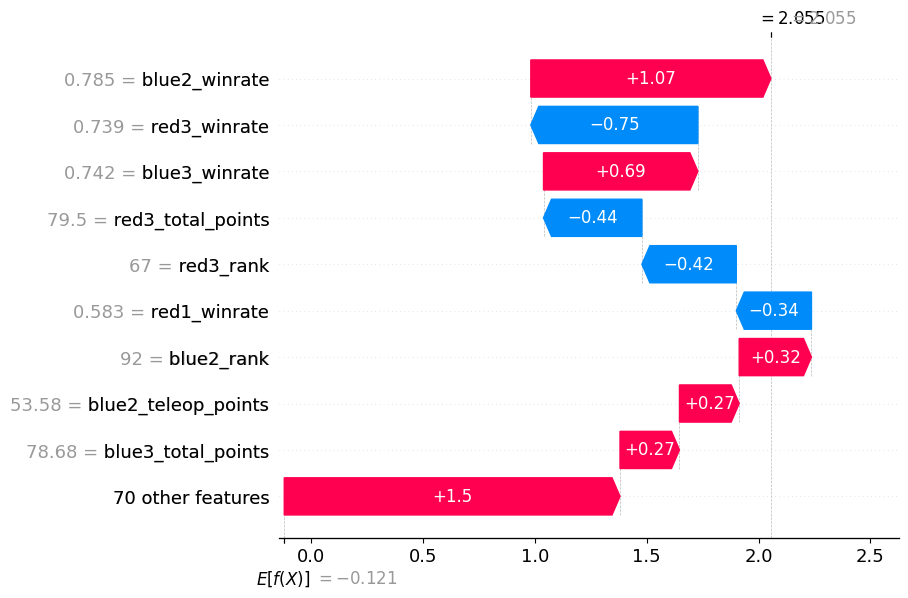

(True,)

In [182]:
inference(100, True)

In [136]:
count = 0
ROWS = 10
for i in range(ROWS):
    pred = inference(i, False)
    
    if pred:
        count += 1

print(f"\n\nAccuracy: {(count/ROWS)*100:.2f}")
    



Accuracy: 100.00


In [137]:
cm = confusion_matrix(y_test, pred_test)

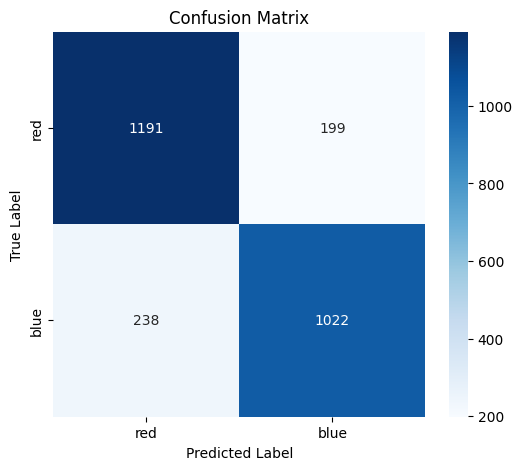

In [138]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['red', 'blue'], yticklabels=['red', 'blue'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:

bst = model.get_booster()
print(bst.feature_names)
bst.save_model("models/classification/classification.json")

In [ ]:
from xgboost import plot_tree
plot_tree(model, tree_idx=10)
plt.title("XGBoost model")
plt.show()

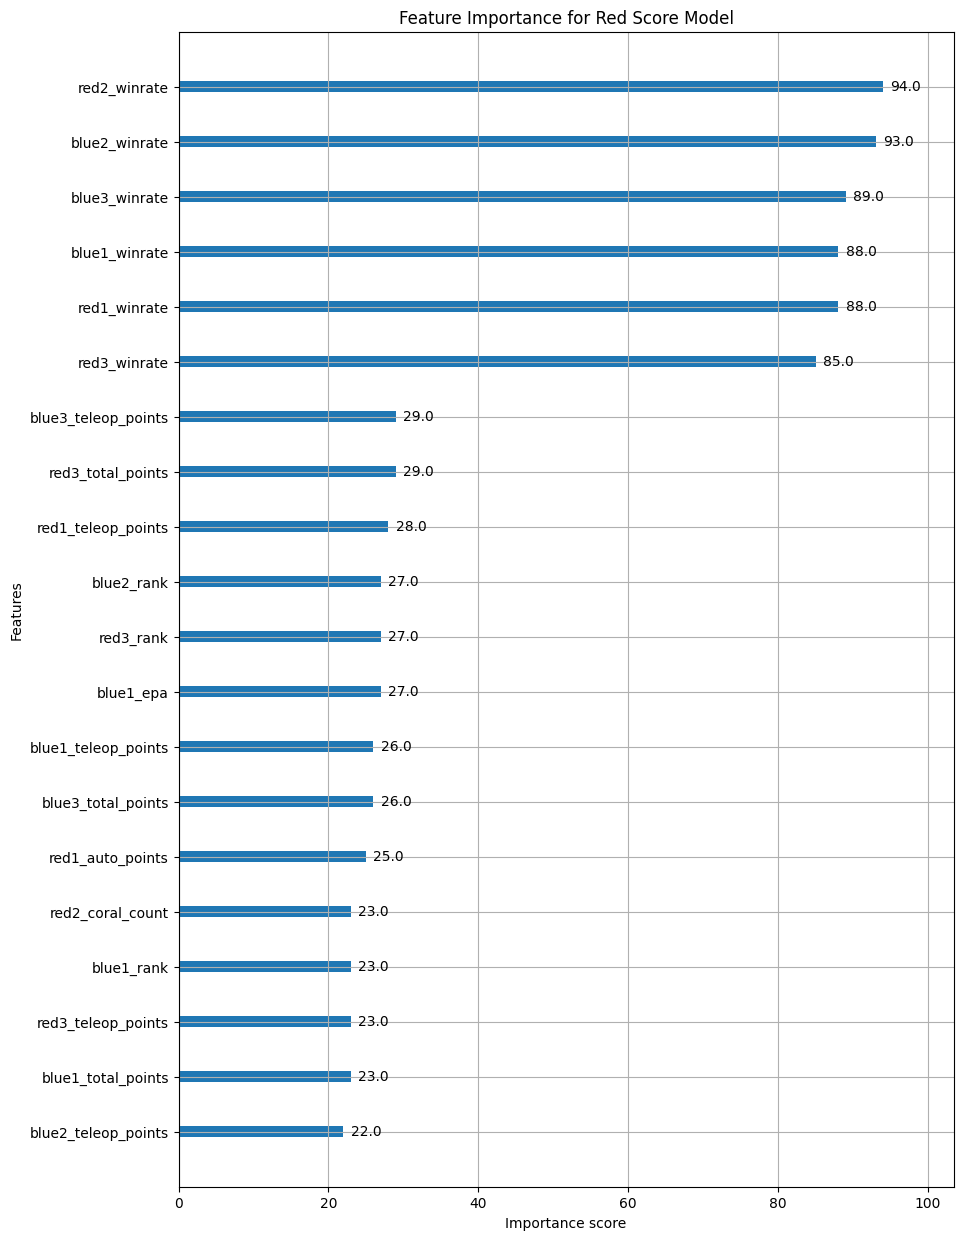

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 15))
plot_importance(model, ax=ax, max_num_features=20) 
plt.title("Feature Importance for Red Score Model")
plt.show()